In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import warnings

warnings.filterwarnings('ignore')

# Конфигурация подключения (должна быть объявлена ПЕРЕД использованием)
DB_HOST = '3.74.122.135'
DB_PORT = '5432'
DB_NAME = 'postgres'
DB_USER = 'team_twenty'
DB_PASSWORD = 'kO4%mU9@fH'
TEAM_SCHEMA = 'schema_twenty'

# Экранирование пароля
encoded_password = quote_plus(DB_PASSWORD)

# Создаем подключение (единственный вызов)
engine = create_engine(
    f"postgresql://{DB_USER}:{encoded_password}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    connect_args={'options': f'-csearch_path={TEAM_SCHEMA}'}
)

# Проверка подключения
try:
    with engine.connect() as test_conn:
        test_conn.execute(text("SELECT 1"))
    print("Database connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")
    exit()

# Выполняем основной запрос
query = text("""
    SELECT 
        recency_days,
        frequency,
        monetary_value
    FROM rfm_unified
""")

try:
    with engine.connect() as connection:
        data = pd.read_sql(query, connection)
    print(f"Successfully loaded {len(data)} records")
    
except Exception as e:
    print(f"Error executing query: {e}")

Database connection successful!
Successfully loaded 888496 records


In [4]:
# Предобработка данных
def preprocess_rfm(df):
    # Обработка выбросов
    df = df[(df['recency_days'] <= df['recency_days'].quantile(0.99)) & 
            (df['monetary_value'] <= df['monetary_value'].quantile(0.99))]
    
    # Логарифмическое преобразование
    df['log_monetary'] = np.log1p(df['monetary_value'])
    df['log_frequency'] = np.log1p(df['frequency'])
    
    return df

data_clean = preprocess_rfm(data)


In [5]:
# Нормализация
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_clean[['recency_days', 'log_frequency', 'log_monetary']])



In [18]:
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import signal
import sys
import os  # Добавлен импорт для работы с файлами
import numpy as np  # Добавлен импорт для numpy

class InterruptHandler:
    def __init__(self):
        self.signal_received = False
        signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = True
        print("\nInterrupt received. Saving current state...")

def optimized_kmeans_analysis(data, max_clusters=4, auto_save_interval=2):
    # Инициализация обработчика прерываний
    interrupt = InterruptHandler()
    
    # Конфигурация сохранения
    results = []
    save_path = "kmeans_analysis_results.pkl"
    
    # Прогресс-бар для основного цикла
    with tqdm(total=max_clusters-1, desc="Optimizing K-means") as pbar:
        for k in range(1, max_clusters+1):
            if interrupt.signal_received:
                break
                
            # Оптимизированные параметры для больших данных
            kmeans = KMeans(
                n_clusters=k,
                init='k-means++',
                n_init=1,
                max_iter=100,
                algorithm='elkan',
                random_state=42
            )
            
            # Обучение с прогресс-баром
            with tqdm(total=100, desc=f'K={k} fitting', leave=False) as inner_pbar:
                kmeans.fit(data)
                inner_pbar.update(100)
            
            # Вычисление метрик
            labels = kmeans.labels_
            
            # Ускоренный расчет силуэта
            if len(np.unique(labels)) > 1:
                silhouette = silhouette_score(
                    data, 
                    labels,
                    sample_size=5000,
                    random_state=42
                )
            else:
                silhouette = -1
                
            # Сохранение результатов
            results.append({
                'k': k,
                'wcss': kmeans.inertia_,
                'silhouette': silhouette,
                'model': kmeans,
                'labels': labels
            })
            
            # Автосохранение
            if k % auto_save_interval == 0:
                save_progress(results, save_path)  # Убрано self
            
            pbar.update(1)
    
    # Финальное сохранение
    save_progress(results, save_path)  # Убрано self
    return results

def save_progress(results, path):
    """Безопасное сохранение результатов"""
    temp_path = f"{path}.tmp"
    try:
        joblib.dump(results, temp_path)
        os.replace(temp_path, path)
        print(f"Progress saved to {path}")
    except Exception as e:
        print(f"Error saving progress: {str(e)}")



def visualize_results(results):
    """Визуализация результатов с сохранением в файл"""
    df = pd.DataFrame([{
        'k': r['k'],
        'wcss': r['wcss'],
        'silhouette': r['silhouette']
    } for r in results])
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # Elbow plot
    ax[0].plot(df['k'], df['wcss'], 'bo-')
    ax[0].set_title('Elbow Method')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    # Silhouette plot
    ax[1].plot(df['k'], df['silhouette'], 'go-')
    ax[1].set_title('Silhouette Scores')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Score')
    
    plt.savefig('kmeans_analysis.png')
    plt.show()
    plt.close()
    
    # Сохранение таблицы
    df.to_csv('kmeans_metrics.csv', index=False)
    print("Visualization results saved to kmeans_analysis.png and kmeans_metrics.csv")

# Использование:
if __name__ == "__main__":
    # Загрузка данных
    data = data_clean  # Ваша функция загрузки данных
    
    # Нормализация
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_clean[['recency_days', 'log_frequency', 'log_monetary']])
    
    # Запуск анализа
    results = optimized_kmeans_analysis(scaled_data)
    
    # Визуализация и сохранение
    visualize_results(results)
    
    # Сохранение финальной модели
    best_result = max(results, key=lambda x: x['silhouette'])
    joblib.dump(best_result['model'], 'best_kmeans_model.pkl')
    print(f"Best model saved (k={best_result['k']})")

Optimizing K-means:   0%|          | 0/3 [00:00<?, ?it/s]

K=1 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

K=2 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

Progress saved to kmeans_analysis_results.pkl


K=3 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

K=4 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

Progress saved to kmeans_analysis_results.pkl
Progress saved to kmeans_analysis_results.pkl
Visualization results saved to kmeans_analysis.png and kmeans_metrics.csv
Best model saved (k=3)


Optimizing K-means:   0%|          | 0/3 [00:00<?, ?it/s]

K=1 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

K=2 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

Progress saved to kmeans_analysis_results.pkl


K=3 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

K=4 fitting:   0%|          | 0/100 [00:00<?, ?it/s]

Progress saved to kmeans_analysis_results.pkl
Progress saved to kmeans_analysis_results.pkl
Model best_kmeans saved successfully


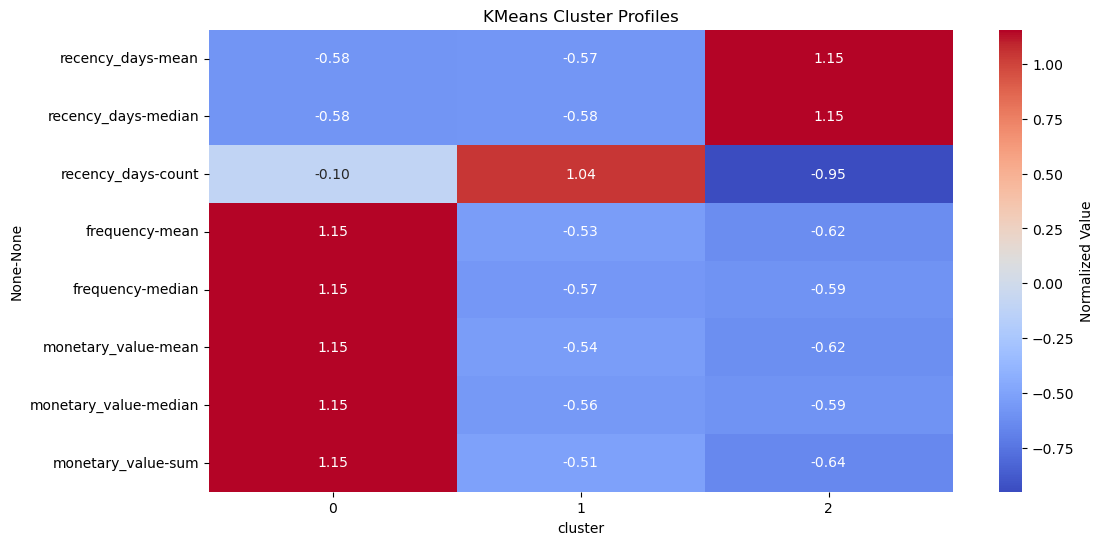

t-SNE Visualization:   0%|          | 0/3 [00:00<?, ?it/s]

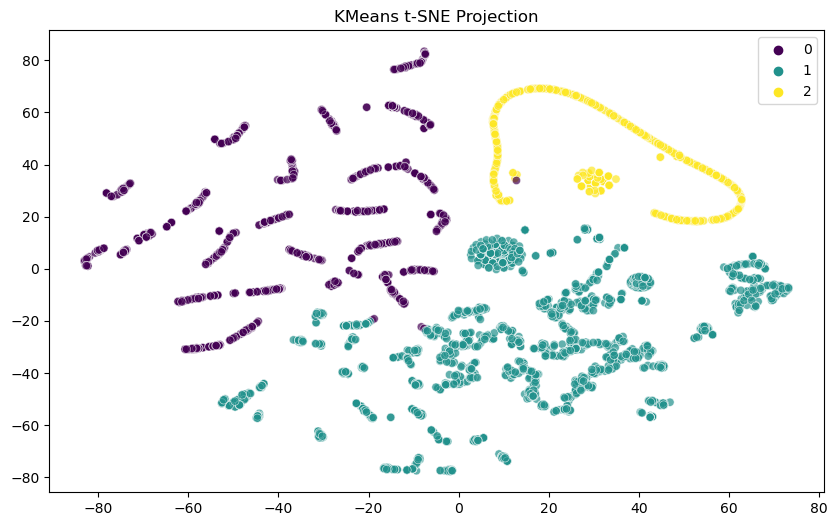

Analysis completed successfully


In [26]:
from tqdm.auto import tqdm
import joblib
import os



# Улучшенный анализ кластеров с сохранением
def analyze_clusters(labels, data, algorithm_name):
    """Анализ кластеров с автоматическим сохранением отчетов"""
    try:
        cluster_profile = data.assign(cluster=labels).groupby('cluster').agg({
            'recency_days': ['mean', 'median', 'count'],
            'frequency': ['mean', 'median'],
            'monetary_value': ['mean', 'median', 'sum']
        })
        
        # Сохранение полного отчета
        report_path = f'{algorithm_name}_cluster_report.csv'
        cluster_profile.to_csv(report_path)
        
        # Нормализация для визуализации
        normalized = cluster_profile.apply(lambda x: (x - x.mean())/x.std())
        
        plt.figure(figsize=(12,6))
        sns.heatmap(
            normalized.T,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            cbar_kws={'label': 'Normalized Value'}
        )
        plt.title(f'{algorithm_name} Cluster Profiles')
        plt.savefig(f'{algorithm_name}_heatmap.png')
        plt.show()
        plt.close()
        
        return cluster_profile
    
    except Exception as e:
        print(f"Cluster analysis failed: {str(e)}")
        return None


# Оптимизированная t-SNE визуализация
def plot_tsne(data, labels, algorithm_name, sample_size=5000):
    """Ускоренная t-SNE визуализация с подвыборкой"""
    try:
        if len(data) > sample_size:
            indices = np.random.choice(data.shape[0], sample_size, replace=False)
            data_sample = data[indices]
            labels_sample = labels[indices]
        else:
            data_sample = data
            labels_sample = labels
        
        with tqdm(total=3, desc="t-SNE Visualization") as pbar:
            tsne = TSNE(n_components=2, random_state=42)
            pbar.update(1)
            
            tsne_data = tsne.fit_transform(data_sample)
            pbar.update(1)
            
            plt.figure(figsize=(10,6))
            sns.scatterplot(
                x=tsne_data[:,0],
                y=tsne_data[:,1],
                hue=labels_sample,
                palette='viridis',
                alpha=0.7
            )
            plt.title(f'{algorithm_name} t-SNE Projection')
            plt.savefig(f'{algorithm_name}_tsne.png')
            plt.show()
            plt.close()
            pbar.update(1)
    
    except Exception as e:
        print(f"t-SNE visualization failed: {str(e)}")

# Автоматическое сохранение моделей
def save_model(model, model_name):
    """Сохранение модели с проверкой ошибок"""
    try:
        joblib.dump(model, f'{model_name}.pkl')
        print(f"Model {model_name} saved successfully")
    except Exception as e:
        print(f"Error saving model {model_name}: {str(e)}")

# Основной пайплайн
def main_analysis_pipeline(data):
    """Полный анализ с обработкой ошибок и сохранением"""
    try:
        # Нормализация данных
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        joblib.dump(scaler, 'scaler.pkl')
        
        # K-means анализ
        kmeans_results = optimized_kmeans_analysis(scaled_data)
        best_kmeans = max(kmeans_results, key=lambda x: x['silhouette'])
        save_model(best_kmeans['model'], 'best_kmeans')
        
        # Анализ K-means
        kmeans_profile = analyze_clusters(
            best_kmeans['labels'], 
            data, 
            'KMeans'
        )
        
        # Визуализации
        # plot_distributions(data, best_kmeans['labels'], 'KMeans')
        plot_tsne(scaled_data, best_kmeans['labels'], 'KMeans')
        
        
        print("Analysis completed successfully")
    
    except Exception as e:
        print(f"Main pipeline failed: {str(e)}")
        raise

# Запуск анализа
if __name__ == "__main__":
    data = data_clean  # Ваша функция загрузки данных
    main_analysis_pipeline(data)

In [27]:
def print_cluster_analysis(results, scaler, feature_names, data_clean):
    # Выбираем лучшую модель
    best_result = max(results, key=lambda x: x['silhouette'])
    kmeans = best_result['model']
    clusters = best_result['labels']
    
    # Обратное преобразование центроидов
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    centers_df = pd.DataFrame(centers_original, columns=feature_names)
    centers_df.index = [f"Cluster {i}" for i in range(centers_df.shape[0])]
    
    # Размеры кластеров
    cluster_sizes = pd.Series(clusters).value_counts().sort_index()
    
    # Функции для описания характеристик
    def describe_recency(value):
        q75 = centers_df['recency_days'].quantile(0.75)
        q25 = centers_df['recency_days'].quantile(0.25)
        if value > q75: return "Inactive"
        if value < q25: return "Very Active"
        return "Moderately Active"

    def describe_frequency(value):
        q75 = centers_df['log_frequency'].quantile(0.75)
        q25 = centers_df['log_frequency'].quantile(0.25)
        if value > q75: return "Frequent Buyer"
        if value < q25: return "Occasional Buyer"
        return "Regular Buyer"

    def describe_monetary(value):
        q75 = centers_df['log_monetary'].quantile(0.75)
        q25 = centers_df['log_monetary'].quantile(0.25)
        if value > q75: return "High-Value"
        if value < q25: return "Low-Value"
        return "Medium-Value"

    # Вывод результатов
    print(f"\n--- RFM Cluster Analysis (k={best_result['k']}) ---")
    print("Cluster Centers:")
    print(centers_df)
    
    print("\nDetailed Cluster Profiles:")
    for cluster in centers_df.index:
        cluster_id = int(cluster.split()[-1])
        size = cluster_sizes.get(cluster_id, 0)
        perc = size/len(clusters)*100
        
        recency = centers_df.loc[cluster, 'recency_days']
        frequency = centers_df.loc[cluster, 'log_frequency']
        monetary = centers_df.loc[cluster, 'log_monetary']
        
        print(f"\n● {cluster} ({size} клиентов, {perc:.1f}%)")
        print(f"├─ Recency:   {recency:.1f} дней ({describe_recency(recency)})")
        print(f"├─ Frequency: {frequency:.1f} транзакций ({describe_frequency(frequency)})")
        print(f"└─ Monetary:  ${monetary:.2f} ({describe_monetary(monetary)})")
        
        # Рекомендации
        print("Рекомендуемые действия:")
        if "Inactive" in describe_recency(recency):
            print("│  • Реактивация: персонализированные предложения")
            print("│  • Проверить причины отсутствия активности")
        if "High-Value" in describe_monetary(monetary):
            print("│  • VIP-обслуживание: персональный менеджер")
            print("│  • Эксклюзивные инвестиционные предложения")
        if "Frequent" in describe_frequency(frequency):
            print("│  • Программа лояльности для частых клиентов")
            print("│  • Бонусы за повторные операции")
        print("└──────────────────────────────────────────────")

    # Сохранение в файл
    report = centers_df.copy()
    report['size'] = cluster_sizes.values
    report['size_perc'] = (report['size']/report['size'].sum()*100).round(1)
    report.to_csv('cluster_profiles.csv')
    print("\nОтчет сохранен в cluster_profiles.csv")

# Добавьте этот вызов в секцию __main__
if __name__ == "__main__":
    # ... предыдущий код ...
    
    # Сохранение финальной модели
    best_result = max(results, key=lambda x: x['silhouette'])
    joblib.dump(best_result['model'], 'best_kmeans_model.pkl')
    print(f"Best model saved (k={best_result['k']})")
    
    # Новый вывод результатов
    feature_names = ['recency_days', 'log_frequency', 'log_monetary']
    print_cluster_analysis(
        results, 
        scaler,
        feature_names,
        data_clean
    )

Best model saved (k=3)

--- RFM Cluster Analysis (k=3) ---
Cluster Centers:
           recency_days  log_frequency  log_monetary
Cluster 0      7.318628       7.490772     13.337028
Cluster 1     92.796756       2.743145      7.654960
Cluster 2   9268.000000       0.032488      4.886215

Detailed Cluster Profiles:

● Cluster 0 (459198 клиентов, 52.1%)
├─ Recency:   7.3 дней (Very Active)
├─ Frequency: 7.5 транзакций (Frequent Buyer)
└─ Monetary:  $13.34 (High-Value)
Рекомендуемые действия:
│  • VIP-обслуживание: персональный менеджер
│  • Эксклюзивные инвестиционные предложения
│  • Программа лояльности для частых клиентов
│  • Бонусы за повторные операции
└──────────────────────────────────────────────

● Cluster 1 (260814 клиентов, 29.6%)
├─ Recency:   92.8 дней (Moderately Active)
├─ Frequency: 2.7 транзакций (Regular Buyer)
└─ Monetary:  $7.65 (Medium-Value)
Рекомендуемые действия:
└──────────────────────────────────────────────

● Cluster 2 (161749 клиентов, 18.3%)
├─ Recency:   9